In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.signal import convolve2d
from scipy.signal import correlate2d
import cv2
from sklearn.model_selection import train_test_split

In [3]:
class CNN:
    def __init__(self, input_size, conv1, conv2, layer1, layer2, lr=0.01, max_pooling_size=(2, 2)):
        self.lr = lr
        self.max_pooling_size = max_pooling_size
        c = 0.05
        self.conv1_w = np.random.normal(0, c, (conv1[0], input_size, *conv1[1:]))  # сверточный слой 1
        self.conv2_w = np.random.normal(0, c, (conv2[0], conv1[0], *conv2[1:]))    # сверточный слой 2
        self.layer1_w = np.random.normal(0, c, layer1)
        self.layer2_w = np.random.normal(0, c, layer2)
        
        self.conv1_b = np.zeros((conv1[0], input_size))
        self.conv2_b = np.zeros((conv2[0], conv1[0]))
        self.layer1_b = np.zeros((1, layer1[1]))
        self.layer2_b = np.zeros((1, layer2[1]))
        
        self.output_size = layer2[1]
        self.boundary_shape = None
        self.errors = []
    
    def activation_function(self, vec):  
        relu = np.vectorize(lambda x: x if x >= 0 else 0.01*x)
        return relu(vec)
    
    def derivative_function(self, vec):
        relu_df = np.vectorize(lambda x: 1 if x >= 0 else 0.01)
        return relu_df(vec)
    
    def sigmoid(self, x):
        x[x > 50] = 50
        x[x < -50] = -50
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_df(self, x):
        sigmoid_values = self.sigmoid(x)
        return sigmoid_values * (1 - sigmoid_values)
    
    def max_pooling(self, X):
        a, b = self.max_pooling_size
        max_pool = np.zeros(X.shape)
        rows = X.shape[0] // a + 1 if X.shape[0] % a else X.shape[0] // a
        cols = X.shape[1] // b + 1 if X.shape[1] % b else X.shape[1] // b
        for i in range(rows):
            for j in range(cols):
                M = X[i*a:(i+1)*a, j*b:(j+1)*b] 
                temp_M = np.zeros(M.shape)
                temp_M[np.argmax(M) // M.shape[1], np.argmax(M) % M.shape[1]] = 1
                max_pool[i*a:(i+1)*a, j*b:(j+1)*b] = temp_M
        max_pool_mask  = max_pool.astype(bool)
        result = X[max_pool_mask].reshape(rows, cols)
        return result, max_pool_mask
    
    def forward(self, X):
        X = X.copy()
        inputs, outputs = [], [X]
        masks = []
        for w, b in [(self.conv1_w, self.conv1_b), (self.conv2_w, self.conv2_b)]:  # проход по сверточным слоям
            output = []
            for ws, bs in zip(w, b):
                result = np.zeros(np.array(X[0].shape) - np.array(ws[0].shape) + 1)
                for w_, b_, x in zip(ws, bs, X):
                     result += correlate2d(x, w_, mode="valid") + b_
                output.append(result)
            inputs.append(np.array(output))
            X = self.activation_function(output)
            
            mask = []
            output = []
            for x in X:
                x, mask_ = self.max_pooling(x)  # max pooling слой + получение булевых масок
                output.append(x)
                mask.append(mask_)
            
            X = np.array(output)
            masks.append(np.array(mask))
            
            outputs.append(X)
        
        X = X.reshape((1, -1))  # flatten
        if not self.boundary_shape:
            self.boundary_shape = inputs[-1].shape
        inputs[-1] = inputs[-1].reshape((1, -1))
        outputs[-1] = X
        
        for w, b in [(self.layer1_w, self.layer1_b)]:
            X = X @ w + b 
            inputs.append(X)
            X = self.activation_function(X)
            outputs.append(X)
        X = X @ self.layer2_w + self.layer2_b
        self.inp = X
        proba = self.sigmoid(X)
        
        return inputs, outputs, proba, masks
    
    def change_weights(self, weights, bias, reduce=True):
        if reduce:
            self.layer2_w -= self.lr * weights[0]
            self.layer2_b -= self.lr * bias[0]
            self.layer1_w -= self.lr * weights[1]
            self.layer1_b -= self.lr * bias[1]
            self.conv2_w -= self.lr * np.array(weights[2])
            self.conv2_b -= self.lr * np.array(bias[2])
            self.conv1_w -= self.lr * np.array(weights[3])
            self.conv1_b -= self.lr * np.array(bias[3])
        else:
            self.layer2_w = weights[3]
            self.layer2_b = bias[3]
            self.layer1_w = weights[2]
            self.layer1_b = bias[2]
            self.conv2_w = np.array(weights[1])
            self.conv2_b = np.array(bias[1])
            self.conv1_w = np.array(weights[0])
            self.conv1_b = np.array(bias[0])
    
    def train(self, X, y, epochs=15):
        errors = []
        best_error = float("inf")
        best_weights = [self.conv1_w, self.conv2_w, self.layer1_w, self.layer2_w]
        best_bias = [self.conv1_b, self.conv2_b, self.layer1_b, self.layer2_b]
        for k in range(epochs):
            indx = np.random.permutation(len(y))
            X, y = X[indx], y[indx]
            error = 0
            for x_i, y_i in zip(X, y):
                inputs, outputs, df, masks = self.forward(x_i)
                df_return = df
                label = np.zeros((1, self.output_size))
                label[0, y_i] = 1
                
                error += np.sum((df - label)**2)  # MSE
                df = (df - label) * self.sigmoid_df(self.inp)  # Производная от MSE
                dw1 = outputs[-1].T @ df
                db1 = df

                df = (df @ self.layer2_w.T) * self.derivative_function(inputs[-1])
                dw2 = outputs[-2].T @ df
                db2 = df
                mask = np.zeros(masks[-1].shape)  # Применяется булевая маска с max pooling слоя
                mask[masks[-1]] = (df @ self.layer1_w.T)[0]
                df = mask * (self.derivative_function(inputs[-2]).reshape(self.boundary_shape))
                conv_w = []  # производная по w
                for w in df:
                    corrs = []
                    for x in outputs[-3]:
                        corrs.append(correlate2d(x, w, mode="valid"))
                    conv_w.append(np.array(corrs))
                dw3 = conv_w
                db3 = np.ones(self.conv2_b.shape) * df.reshape((df.shape[0], -1)).sum(axis=1).reshape(-1, 1)
                    
                conv_x = []  # производная по x
                for df_i, w_i in zip(df, self.conv2_w):
                    convs = []
                    for w in w_i:
                        convs.append(convolve2d(df_i, w))
                    conv_x.append(np.array(convs))
                    
                conv_size = inputs[-3].shape[0]
                df = np.sum(conv_x, axis=0)
                mask = np.zeros(masks[-2].shape)
                mask[masks[-2]] = df.reshape(-1)
                df = mask * self.derivative_function(inputs[-3])
                conv_w = []
                for w in df:
                    corrs = []
                    for x in outputs[-4]:
                        corrs.append(correlate2d(x, w, mode="valid"))
                    conv_w.append(np.array(corrs))
                dw4 = conv_w
                db4 = np.ones(self.conv1_b.shape) * df.reshape((conv_size, -1)).sum(axis=1).reshape(-1, 1)
                
                weigths = [dw1, dw2, dw3, dw4]
                bias = [db1, db2, db3, db4]
                self.change_weights(weigths, bias)
            
            if error < best_error:
                best_error = error
                best_weights = [self.conv1_w, self.conv2_w, self.layer1_w, self.layer2_w]
                best_bias = [self.conv1_b, self.conv2_b, self.layer1_b, self.layer2_b]
                
            errors.append(error)
            print(f"Эпоха - {k}, loss - {error}")
            
        self.errors += errors
        self.change_weights(best_weights, best_bias, reduce=False)
                

# Тест на цифрах mnist

In [31]:
test = pd.read_csv("C:/Users/Ilsaf/Desktop/mnist/mnist_test.csv")
train = pd.read_csv("C:/Users/Ilsaf/Desktop/mnist/mnist_train.csv")

In [32]:
X_train, y_train = np.array(train.drop("label", axis=1)), np.array(train["label"])
X_test, y_test = np.array(test.drop("label", axis=1)), np.array(test["label"])

In [33]:
X_train = X_train[:15000]
y_train = y_train[:15000]

In [34]:
X_train = X_train / 255
X_test = X_test / 255

In [35]:
X_train_list = []
for x in X_train:
    X_train_list.append(np.array(x).reshape((1, 28, 28)))
X_train = np.array(X_train_list)

X_test_list = []
for x in X_test:
    X_test_list.append(np.array(x).reshape((1, 28, 28)))
X_test = np.array(X_test_list)

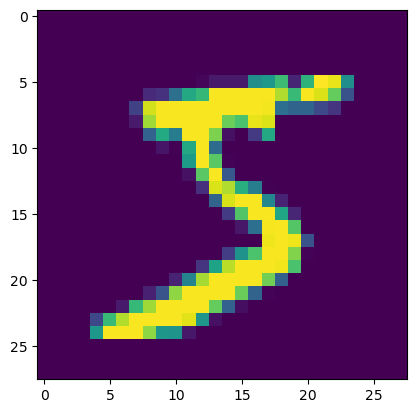

In [36]:
plt.imshow(X_train[0, 0]);

In [41]:
cnn = CNN(input_size=1,
          conv1=(8, 5, 5), 
          conv2=(8, 8, 8), 
          layer1=(72, 80), 
          layer2= (80, 10), 
          lr=0.01, 
          max_pooling_size=(2, 2))

In [42]:
%%time
cnn.train(X_train, y_train, epochs=10)

Эпоха - 0, loss - 10325.702120643413
Эпоха - 1, loss - 3496.7072537572108
Эпоха - 2, loss - 2452.9568454839114
Эпоха - 3, loss - 1932.6133496187056
Эпоха - 4, loss - 1622.9770565618126
Эпоха - 5, loss - 1363.7671702712767
Эпоха - 6, loss - 1173.3129678369223
Эпоха - 7, loss - 1038.5302838614755
Эпоха - 8, loss - 940.6740322685649
Эпоха - 9, loss - 852.8867154573596
CPU times: total: 36min 55s
Wall time: 36min 55s


In [43]:
pred = np.array([np.argmax(cnn.forward(x)[2]) for x in X_train])
np.mean(pred == y_train)  # точность на трейне

0.9672

In [44]:
pred = np.array([np.argmax(cnn.forward(x)[2]) for x in X_test])
np.mean(pred == y_test)  # точность на тесте

0.9526

# Фильтры

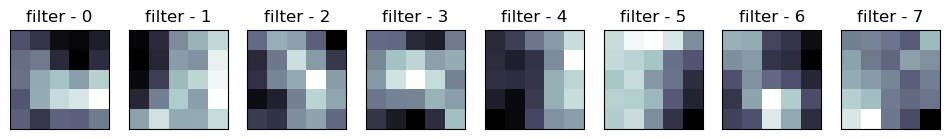

In [45]:
x_len, y_len = cnn.conv1_w.shape[:2]
fig, axs = plt.subplots(nrows=y_len, ncols=x_len, figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})

for i in range(x_len):
    axs[i].imshow(cnn.conv1_w[i, 0], cmap='bone')
    axs[i].set_title(f"filter - {i}")

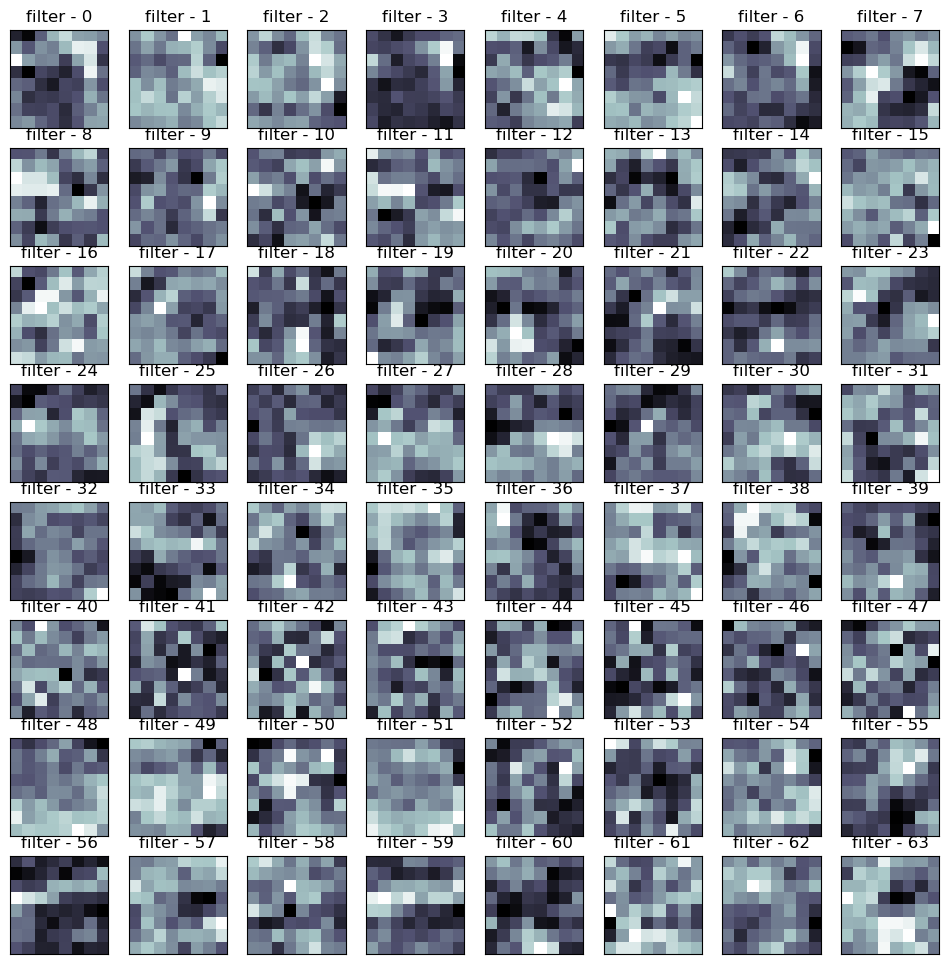

In [47]:
x_len, y_len = cnn.conv2_w.shape[:2]
fig, axs = plt.subplots(nrows=x_len, ncols=y_len, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

for i in range(x_len):
    for j in range(y_len):
        axs[i, j].imshow(cnn.conv2_w[i, j], cmap='bone')
        axs[i, j].set_title(f"filter - {i*x_len+j}")

# Тест на кошках и собачках

In [48]:
def resize(img, width, height):
    resized_img = [cv2.resize(img_, (width, height)) for img_ in img]
    return np.array(resized_img)

In [49]:
cats = []
for i in range(1, 4001):
    image = cv2.imread(f"C:/Users/Ilsaf/Desktop/mnist/train/cats/cat.{i}.jpg")
    images = np.array(cv2.split(image))
    images = resize(images, 100, 100)[:1] / 255
    cats.append(images)

In [50]:
dogs = []
for i in range(1, 4001):
    image = cv2.imread(f"C:/Users/Ilsaf/Desktop/mnist/train/dogs/dog.{i}.jpg")
    images = np.array(cv2.split(image))
    images = resize(images, 100, 100)[:1] / 255
    dogs.append(images)

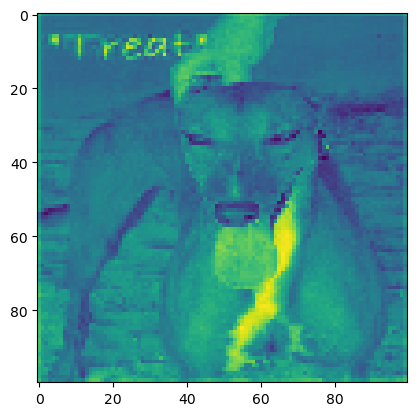

In [51]:
plt.imshow(dogs[1000][0]);

In [52]:
y = np.array([0]*4000 + [1]*4000)

In [53]:
X = np.concatenate((cats, dogs))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17, stratify=y)

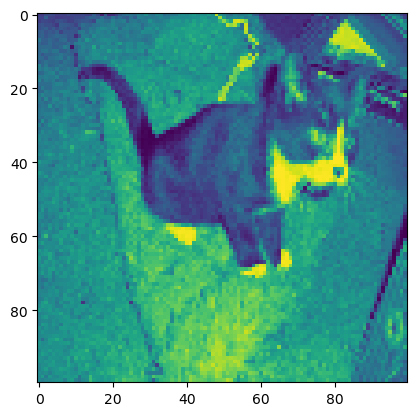

In [55]:
plt.imshow(X_train[100][0]);

In [56]:
X_train.shape, y_train.shape

((5360, 1, 100, 100), (5360,))

In [408]:
cnn = CNN(input_size=1,
          conv1=(8, 5, 5), 
          conv2=(8, 8, 8), 
          layer1=(72, 80), 
          layer2= (80, 2), 
          lr=0.05, 
          max_pooling_size=(5, 5))

In [409]:
cnn.train(X_train, y_train, epochs=50)

Эпоха - 0, loss - 2683.802551888517
Эпоха - 1, loss - 2674.304341662999
Эпоха - 2, loss - 2634.989286040499
Эпоха - 3, loss - 2618.268176734692
Эпоха - 4, loss - 2605.8331819759924
Эпоха - 5, loss - 2596.431475849649
Эпоха - 6, loss - 2587.9500559336366
Эпоха - 7, loss - 2574.7721394104233
Эпоха - 8, loss - 2582.474230584166
Эпоха - 9, loss - 2642.142944103988
Эпоха - 10, loss - 2624.345748942282
Эпоха - 11, loss - 2571.101188584717
Эпоха - 12, loss - 2575.4099231437835
Эпоха - 13, loss - 2540.5288153061574
Эпоха - 14, loss - 2543.3529674264223
Эпоха - 15, loss - 2553.3600758263465
Эпоха - 16, loss - 2519.1664409741684
Эпоха - 17, loss - 2519.7033411337056
Эпоха - 18, loss - 2490.684871119558
Эпоха - 19, loss - 2506.0950255418693
Эпоха - 20, loss - 2504.0068545391564
Эпоха - 21, loss - 2433.550727752787
Эпоха - 22, loss - 2459.3033743593637
Эпоха - 23, loss - 2458.446760306867
Эпоха - 24, loss - 2428.588986892274
Эпоха - 25, loss - 2447.610873269226
Эпоха - 26, loss - 2435.983968993348

In [424]:
cnn.train(X_train, y_train, epochs=15)

Эпоха - 0, loss - 2399.182535477576
Эпоха - 1, loss - 2310.2705752153324
Эпоха - 2, loss - 2219.6787786942014
Эпоха - 3, loss - 2100.892766433031
Эпоха - 4, loss - 2052.8569997330696
Эпоха - 5, loss - 1984.774277620191
Эпоха - 6, loss - 2005.381325810466
Эпоха - 7, loss - 2041.530217195153
Эпоха - 8, loss - 1958.1535252593073
Эпоха - 9, loss - 1939.7162304929218
Эпоха - 10, loss - 1920.970977137324
Эпоха - 11, loss - 1913.122305971303
Эпоха - 12, loss - 1916.9517130274098
Эпоха - 13, loss - 1903.0736854538832
Эпоха - 14, loss - 1878.8246137500737


In [446]:
cnn.train(X_train, y_train, epochs=15)

Эпоха - 0, loss - 1439.7405308538364
Эпоха - 1, loss - 1419.8719780768567
Эпоха - 2, loss - 1399.2312018066934
Эпоха - 3, loss - 1376.8617262539926
Эпоха - 4, loss - 1369.465163865227
Эпоха - 5, loss - 1356.7594464376104
Эпоха - 6, loss - 1339.7897460499164
Эпоха - 7, loss - 1318.821762972413
Эпоха - 8, loss - 1328.4043235894135
Эпоха - 9, loss - 1319.5341931867176
Эпоха - 10, loss - 1314.9446867410918
Эпоха - 11, loss - 1306.6564996215222
Эпоха - 12, loss - 1295.461402128916
Эпоха - 13, loss - 1283.4581450881155
Эпоха - 14, loss - 1279.9249975057335


In [458]:
cnn.train(X_train, y_train, epochs=5)

Эпоха - 0, loss - 1193.8780898053863
Эпоха - 1, loss - 1193.460398117022
Эпоха - 2, loss - 1185.6998405849658
Эпоха - 3, loss - 1185.3527064261389
Эпоха - 4, loss - 1155.407980816986


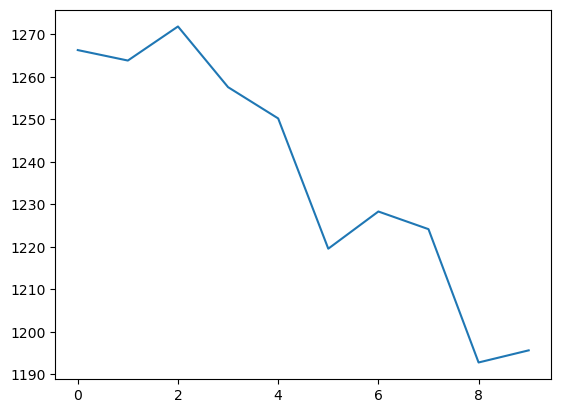

In [455]:
plt.plot(cnn.errors)

In [461]:
pred = np.array([np.argmax(cnn.forward(x)[2]) for x in X_train])
np.mean(pred == y_train)  # точность на трейне

0.8677238805970149

In [462]:
pred = np.array([np.argmax(cnn.forward(x)[2]) for x in X_test])
np.mean(pred == y_test)  # точность на тесте

0.7003787878787879

# Фильтры

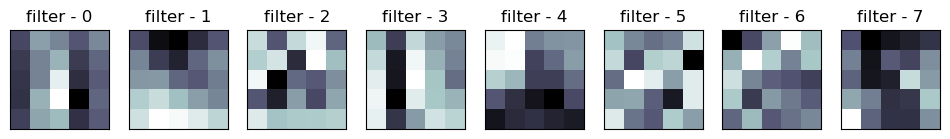

In [472]:
x_len, y_len = cnn.conv1_w.shape[:2]
fig, axs = plt.subplots(nrows=y_len, ncols=x_len, figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})

for i in range(x_len):
    axs[i].imshow(cnn.conv1_w[i, 0], cmap='bone')
    axs[i].set_title(f"filter - {i}")


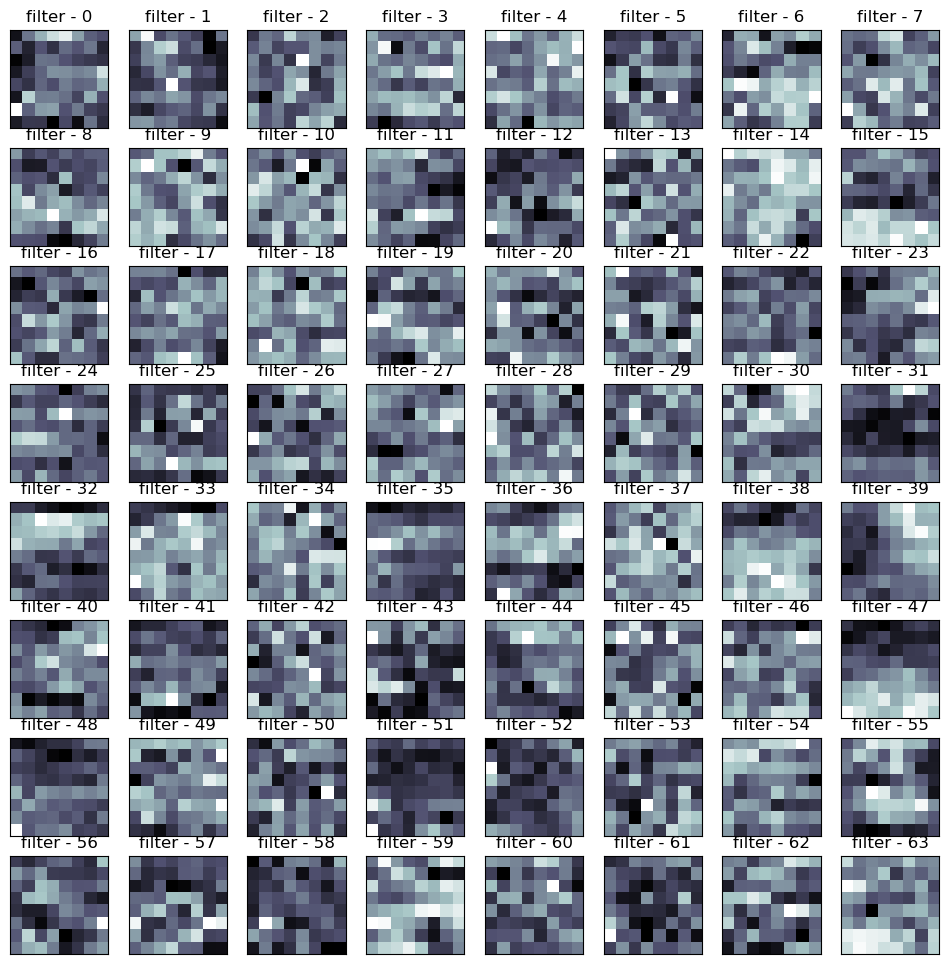

In [473]:
x_len, y_len = cnn.conv2_w.shape[:2]
fig, axs = plt.subplots(nrows=x_len, ncols=y_len, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
i = 1
for i in range(x_len):
    for j in range(y_len):
        axs[i, j].imshow(cnn.conv2_w[i, j], cmap='bone')
        axs[i, j].set_title(f"filter - {i*x_len+j}")


# Нейросети на PyTorch

PyTorch при прямом проходе строит граф вычислений, а при обратном проходе вычисляет градиенты для всех узлов, которые требуют вычисления градиентов. Для автоматического дифференцирования используется механизм autograd. [autograd](https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc) хранит запись данных (тензоров) и всех выполненных операций (вместе с полученными новыми тензорами) в направленном ациклическом графе, состоящем из объектов [Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function).

Чтобы autograd отслеживал операции с тензором, у него должен быть установлен флаг **requires_grad = True**, который есть у каждого тензора в PyTorch. Этот флаг контролирует, нужно ли PyTorch отслеживать операции, выполняемые с этим тензором, для последующего вычисления градиентов во время обратного распространения. По умолчанию у тензоров requires_grad = False, для такого тензора градиент не будет вычисляться. Исключение составляют тензоры [nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) (параметры модели).

PyTorch отслеживает операции (записывает их в вычислительный граф, параметр grad_fn) только в том случае, если хотя бы один из входных тензоров операции имеет **requires_grad = True**.

In [3]:
import torch

In [4]:
X = torch.randn(1, 5)
Y = torch.randn(1, 5)

In [5]:
X.requires_grad, Y.requires_grad

(False, False)

In [6]:
X + Y

tensor([[ 0.6066, -0.5563,  1.9459,  0.6894,  0.0784]])

In [7]:
X = torch.randn(1, 5).requires_grad_(True)
Y = torch.randn(1, 5)

In [8]:
X.requires_grad, Y.requires_grad

(True, False)

In [9]:
X + Y

tensor([[ 1.0069, -1.3860,  2.0823, -0.0639,  0.4952]], grad_fn=<AddBackward0>)

### Листовые и нелистовые тензоры

Листовые тензоры - это тензоры, которые не имеют связанной с ними функции градиента (**grad_fn**). Обычно это параметры модели. 

Нелистовые тензоры - это тензоры, которые являются результатом какой-либо операции (например, сложения, умножения, и т.д.) и, следовательно, имеют связанную с ними функцию градиента (**grad_fn**). Эти тензоры автоматически имеют requires_grad=True, так как их градиенты будут необходимы в качестве промежуточного результата для вычисления градиента для листового тензора, который его требует, но градиенты в атрибуте **.grad** сохраняться не будут.

При вызове **.backward()** PyTorch вычисляет градиенты только для тех тензоров, которые являются "листьями" вычислительного графа (то есть не были результатом какой-либо операции) и у которых установлен флаг **requires_grad = True**. Градиенты аккумулируются в поле **.grad** этих тензоров. 

Важно отметить, что после каждого **.backward()** вызова autograd начинает заполнять новый граф (граф создается заново с нуля, а сохраненные промежуточные значения освобождаются). Также чтобы иметь возможность обратного распространения по графу вычислений и вычислять градиенты, PyTorch дополнительно сохранит соответствующие "градиентные функции" выполненных операций в выходном тензоре (сохраненном как атрибут в **.grad_fn**). После завершения прямого прохода можно вызвать **.backward()** метод на выходном (или тензоре функции потерь), которая выполнит обратное распространение по графу вычислений с использованием функций, хранящихся в **grad_fn**.

In [10]:
X = torch.randn(1, 2)
W = torch.randn(2, 2).requires_grad_(True)

In [11]:
out = torch.sum(torch.pow(X @ W, 2))

In [12]:
out

tensor(0.0258, grad_fn=<SumBackward0>)

In [13]:
out.grad_fn

In [14]:
out.grad_fn.next_functions[0][0]

In [15]:
out.grad_fn.next_functions[0][0].next_functions[0][0]

In [16]:
out.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[1][0]

In [17]:
out.backward()

In [18]:
W.grad

tensor([[-0.0801,  0.0868],
        [ 0.0154, -0.0167]])

# [Режимы работы](https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc#:~:text=Default%20Mode) PyTorch

**Default Mode**

* Default mode — это режим, в котором PyTorch работает по умолчанию, когда не используются никакие другие специальные режимы, такие как no-grad или inference.

* Самая важная особенность Default mode заключается в том, что только в этом режиме флаг requires_grad имеет значение и влияет на поведение PyTorch.
  
* Если requires_grad=True для тензора, то PyTorch будет отслеживать операции с ним и вычислять градиенты.

* Если requires_grad=False для тензора, то PyTorch не будет отслеживать операции с ним и не будет вычислять градиенты.

**[No-grad Mode](https://pytorch.org/docs/stable/generated/torch.no_grad.html)**

* No-grad mode — это режим, в котором отключается отслеживание градиентов для определенных операций. В PyTorch этот режим активируется с помощью контекстного менеджера **torch.no_grad()**.

* Внутри No-grad Mode PyTorch ведет себя так, как если бы requires_grad был равен False для всех входных тензоров, то есть ведет себя так, как будто ни один из входов не требует градиента. Тензоры, полученные в результате каких-то операции внутри этого блока, будут иметь **requires_grad = False**, даже если входные тензоры имеют **requires_grad = True**.

* Даже если какие-то из входных тензоров имеют requires_grad=True, операции с ними не записываются в граф вычислений. Это означает, что PyTorch не будет вычислять градиенты этих операций.

* Менеджер контекста **torch.no_grad()** позволяет удобно отключать градиенты для блока кода или функции без необходимости временно устанавливать тензоры на requires_grad=False, а затем обратно на True. Оно используется, когда нужно выполнить операции, которые не должны влиять на градиенты, например, при использовании модели на валидационной выборке либо когда нужно обновить параметры модели на месте без записи этих действий в граф вычислений.

* Менеджер контекста **torch.no_grad()** бывает очень полезен, так как не создает ненужный граф вычислении и ненужные тензоры, которые могли бы использоваться для вычисления градиентов. 

**[Inference Mode](https://pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html)**

* Inference Mode — это еще более строгий вариант No-grad Mode, который разработан специально для задач инференса (предсказания), когда градиенты не нужны вообще. В PyTorch этот режим активируется с помощью контекстного менеджера **torch.inference_mode()**.

* Подобно No-grad Mode, в Inference Mode операции не записываются в граф вычислений, но этот режим также дополнительно оптимизирует выполнение операций.

* PyTorch может использовать более эффективные алгоритмы и оптимизации, которые могут ускорить выполнение модели. Основное ограничение Inference Mode заключается в том, что тензоры, созданные внутри этого режима, не могут быть использованы в операциях, которые должны отслеживаться автоградом, после выхода из этого режима.

### torch.no_grad()

In [19]:
X = torch.randn(1, 5)
W = torch.randn(1, 5).requires_grad_(True)
X.requires_grad, W.requires_grad

(False, True)

In [20]:
with torch.no_grad():
    Y = X + W
Y.requires_grad

False

In [21]:
Y.requires_grad_(True)

tensor([[ 0.2498, -1.7593,  1.0359, -0.9606, -0.2250]], requires_grad=True)

### torch.inference_mode()

In [22]:
with torch.inference_mode():
    Y = X + W
Y.requires_grad

False

In [23]:
Y.requires_grad_(True)

RuntimeError: Setting requires_grad=True on inference tensor outside InferenceMode is not allowed.

# Режим оценки и режим обучения

В PyTorch есть механизмы **model.train()** и **model.eval()**. Эти методы меняют поведение слоев модели во время обучения и во время валидации/инференса. Это важно, потому что некоторые слои имеют разное поведение во время обучения (когда вызывается **model.train()**) и во время оценки (когда вызывается **model.eval()**). Например, **torch.nn.Dropout** и **torch.nn.BatchNorm2d**:

* Во время обучения **torch.nn.Dropout** случайным образом отключает часть нейронов, а во время оценки не отключает ничего.

* Во время обучения **torch.nn.BatchNorm2d** обновляет статистики (среднее и дисперсию) по батчу, а во время оценки использует накопленные статистики, полученные во время обучения.

Если забыть вызвать **model.eval()** перед оценкой, **BatchNorm** будет продолжать обновлять статистики на валидационных данных, что приведет к неправильным результатам, а **Dropout** оставит "замороженными" часть нейронов модели.

Даже если нет уверенности, что модель содержит слои, которые по-разному ведут себя в режимах обучения и оценки, всегда следует вызывать **model.train()** при обучении и **model.eval()** при оценке. Это хорошая практика. В будущем какой-либо модуль может обновиться, и его поведение изменится в зависимости от режима, и это сломает код. Вызов **model.train()** и **model.eval()** гарантирует корректное поведение модели в разных сценариях.

In [4]:
import torch.nn as nn

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(10, 2)
    
    def forward(self, x):
        return self.fc(x)

In [6]:
model = Net()
model(torch.randn(1, 10))

tensor([[ 0.0400, -1.1134]], grad_fn=<AddmmBackward0>)

In [7]:
model.train()
model.training  # флаг, отвечающий за режим обучения и оценки

True

In [8]:
model.eval()
model.training

False

# Классы Dataset и DataLoader

**[Ссылка](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)** и **[Ссылка](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)**

Наследуясь от класса **Dataset**, можно создать свой собственный класс с необходимым функционалом для получения данных по соответствующему индексу. Например, класс можно реализовать так, что он будет подгружать не весь датасет, а только один объект из этого датасета за раз, что экономит ресурсы компьютера. 

Пользовательский класс Dataset должен наследоваться от класса **torch.utils.data.Dataset** и реализовывать три метода : **\_\_init__**, **\_\_len__** и **\_\_getitem__**.

Далее объект класса **Dataset** можно обернуть в класс **DataLoader**, который позволяет итерироваться по батчу данных, перемешивать данные перед каждой эпохой и использовать несколько потоков для ускорения загрузки данных.

# Класс Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import v2
from skimage import transform, io
import pandas as pd
import os

In [5]:
class CustomDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path, "train" if train else "test")   # Путь к директории с данными
        self.transform = transform                                     # Трансформации с данными
        
        self.labels = os.listdir(self.path)                            # Названия меток классов
        self.classes = dict(zip(self.labels, range(len(self.labels))))
        self.targets = torch.eye(len(self.labels)).float()             # Единичная матрица, используется как таргет
        
        self.length = 0
        self.files = []
        for label in self.labels:
            path = os.path.join(self.path, label)                      # Заходим в каждую папку с данными
            files_list = os.listdir(path)                              # и получаем список названии изображении
            self.length += len(files_list)                             # Сохраняем данные в формате (Путь к файлу, Таргет)
            self.files.extend(map(lambda x: (os.path.join(path, x), self.classes[label]), files_list))
                                                                       
    def __len__(self):                                                 # возвращает размер выборки
        return self.length
    
    def __getitem__(self, indx):                                       # возвращает объект из выборки по индексу
        path_file, target = self.files[indx]
        target = self.targets[target]
        image = read_image(path_file) / 255
        
        if self.transform:
            image = self.transform(image)
            
        return {"img": image, "label": target}

### Можно создать собственные преобразователи изображения

In [5]:
class Rescale:
    def __init__(self, output_size=(100, 100)):
        self.output_size = output_size
        
    def __call__(self, sample):
        sample = np.array(sample)
        sample_resized = np.array([transform.resize(img, self.output_size) for img in sample])
        return torch.from_numpy(sample_resized)

### Либо так, как указано в [документации](https://pytorch.org/vision/main/auto_examples/transforms/plot_custom_transforms.html) 

In [6]:
class Rescale(torch.nn.Module):
    def __init__(self, output_size=(100, 100)):
        super(Rescale, self).__init__()
        self.output_size = output_size
        
    def forward(self, sample):
        sample = np.array(sample)
        sample_resized = np.array([transform.resize(img, self.output_size) for img in sample])
        return torch.from_numpy(sample_resized)

### Объединение нескольких трансформации с помощью transforms.v2.Compose

**[Документация о трансформациях](https://pytorch.org/vision/stable/transforms.html)**

In [7]:
image_transforms = v2.Compose( [v2.Resize((220, 220)), 
                                v2.RandomCrop((200, 200)),
                                v2.RandomAffine(degrees=(-10, 10), 
                                                translate=(0.05, 0.05), 
                                                scale=(0.95, 1.05), 
                                                shear=(-3, 3), 
                                                fill=(0)),
                                v2.RandomPhotometricDistort(), 
                                v2.RandomHorizontalFlip()] )

In [8]:
path = r"C:\Users\Ilsaf\Desktop\mnist"

In [9]:
train_dataset = CustomDataset(path,                       
                              transform=image_transforms)

In [10]:
len(train_dataset)

8005

In [15]:
image = train_dataset[1234]["img"]

In [16]:
image.shape

torch.Size([3, 200, 200])

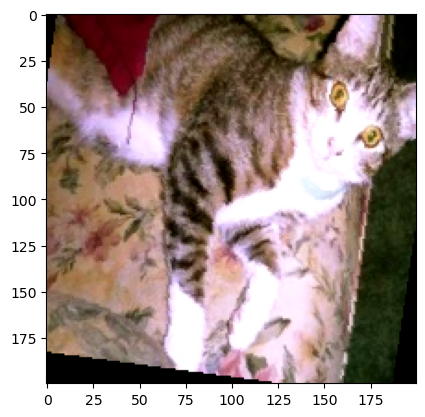

In [17]:
plt.imshow(image.permute(1, 2, 0));

# [Dataloader](https://pytorch.org/docs/stable/data.html#:~:text=Data%20loader%20combines)

In [63]:
dataloader = DataLoader(train_dataset,   # датасет
                        batch_size=32,   # размер батча
                        shuffle=True,    # перемешивать перед каждой эпохой
                        drop_last=True,  # отбрасывает последний неполный батч
                        num_workers=0)   # количество подпроцессов, используемых для загрузки данных

In [64]:
image_batch, target_batch = next(iter(dataloader))

In [65]:
image_batch.shape, target_batch.shape

(torch.Size([32, 3, 150, 150]), torch.Size([32, 2]))

In [66]:
target_batch[:, 0].mean()  # соотношение классов

tensor(0.3750)

# Собственный BatchSampler

In [63]:
from torch.utils.data.sampler import BatchSampler, Sampler
import random

In [64]:
class StratifiedSampler(BatchSampler):
    def __init__(self, data_indx, batch_size=32):
        self.data_indx = data_indx                # словарь формата {таргет: list индексов} 
        for value in self.data_indx.values():
            random.shuffle(value)                 # перемешивание списков для каждого класса
        
        self.batch_size = batch_size
        self.length = sum(map(len, data_indx.values()))  # размер всего датасета
        
        self.class_ratio = dict()                        # словарь для хранения соотношении классов 
        current_size = 0                                 # для дальнейшей стратификации 
        for i, label in enumerate(self.data_indx):
            size = round(batch_size * (len(data_indx[label]) / self.length))  
            self.class_ratio[label] = size
            
            if i == len(self.data_indx) - 1:
                self.class_ratio[label] = self.batch_size - current_size  # для последнего класса специальное условие, чтобы
                                                                          # общее число всех элементов словаря было = batch_size
            current_size += size
            
    def __iter__(self):
        for i in range(self.length // self.batch_size):
            batch = []
            for cls in self.class_ratio:          # для каждого класса проходимся по циклу, добавляем элементы в batch
                size = self.class_ratio[cls]
                value = self.data_indx[cls][i*size:(i+1)*size]
                batch.extend(value)
                
            random.shuffle(batch)                 # перемешивание батча 
            yield batch                           # список индексов
            
    def __len__(self):
        return self.length // self.batch_size

In [65]:
data_indx = {0: list(range(4000)), 1: list(range(4000, 8005))}

In [66]:
dataloader = DataLoader(train_dataset, 
                        batch_sampler=StratifiedSampler(data_indx, batch_size=32))

In [81]:
sample = next(iter(dataloader))
image_batch, target_batch = sample["img"], sample["label"]

In [82]:
image_batch.shape, target_batch.shape

(torch.Size([32, 3, 200, 200]), torch.Size([32, 2]))

In [83]:
target_batch[:, 0].mean()  # соотношение классов в батче одинаковое 

tensor(0.5000)

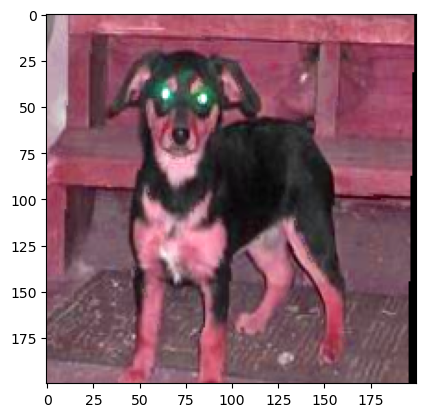

In [84]:
plt.imshow(image_batch[0].permute(1, 2, 0));

# Обучение модели на PyTorch

# [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

**nn.Sequential** $-$ специальный класс-контейнер, который позволяет последовательно работать с составляющими архитектуры нейронной сети (слои, функции активации и т.д.)

In [115]:
model = nn.Sequential( nn.Linear(5, 10), 
                       nn.ReLU(), 
                       nn.Linear(10, 2) )

model( torch.randn(1, 5) )

tensor([[-0.3638, -0.1690]], grad_fn=<AddmmBackward0>)

# [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

**nn.Linear** $-$ класс, отвечающий за линейный слой. 

$y=xA^T+b$ 

**torch.nn.Linear ( in_features, out_features, bias=True ... )**

**in_features** $-$ размер входного тензора

**out_features** $-$ размер выходного тензора

**bias** $-$ включать ли вектор смещении, по умолчанию True 

Форма входного тензора $-$ **( ∗ , in_features )**

Форма входного тензора $-$ **( ∗ , out_features ),** где **∗** означает любое количество измерений

In [122]:
x = torch.randn(2, 2, 3)
print(x.shape)
x = nn.Linear(3, 5)(x)
print(x.shape)

torch.Size([2, 2, 3])
torch.Size([2, 2, 5])


# [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

**torch.nn.Conv2d** $-$ класс, отвечающий за сверточный слой

**[Визуализация параметров](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)**

**torch.nn.Conv2d ( in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros' )**

**in_channels** $-$ количество каналов входного тензора (например, 3 для цветного изображения).

**out_channels** $-$ количество каналов выходного тензора (количество фильтров (ядер), которые применяются к входному тензору).

**kernel_size** $-$ размер фильтра (ядра) свертки. Тип **int** или **tuple**.

**stride** $-$ шаг, с которым фильтр (ядро) перемещается по входному тензору. Определяет, на сколько пикселей перемещается фильтр при каждом шаге. Большой шаг уменьшает размер выходного тензора и позволяет снизить вычислительную нагрузку. Тип **int** или **tuple**.

**padding** $-$ добавляет отступы вокруг границ входного тензора. Позволяет контролировать размер выходного тензора, особенно при использовании больших фильтров. 

* Если **padding** — целое число, отступ одинаков со всех сторон.

* Если **padding** — кортеж, отступ может быть разным по горизонтали и вертикали.

* Если **padding** — строка "valid" (отсутствие padding) или "same" (чтобы размер выхода был таким же, как вход, при этом **stride** должен быть = 1)

**dilation** $-$ увеличивает "разреженность" свертки, пропуская пиксели внутри фильтра (ядра). Это как если бы расширили фильтр (ядро), вставив "дырки" между его элементами.

**[groups](https://docs.google.com/presentation/d/163NU5vYkuqZKUYSYtWg8Hd9zrviuldh0q3P4WYXKjTg/edit#slide=id.g24c65fa43b_0_31)** $-$ управляет соединениями между входами и выходами, причем **in_channels** и **out_channels** должны делиться на **groups**. 

* При **groups** = 1 все входы свертываются со всеми выходами.

* При **groups** = 2 операция становится эквивалентной наличию двух расположенных рядом свёрточных слоев, каждый из которых видит половину входных каналов и создает половину выходных каналов, а затем оба слоя объединяются.

* При **groups** = **in_channels** каждый входной канал сворачивается со своим собственным набором фильтров (размером $\frac{out\_channels}{in\_channels}$)

**bias** $-$ включать ли вектор смещении, по умолчанию True.

**padding_mode** $-$ параметр отвечает за то, чем заполнить отступы **padding**.

* **zeros** $-$ заполнение нулями

* **[reflect](https://pytorch.org/docs/stable/generated/torch.nn.ReflectionPad2d.html#torch.nn.ReflectionPad2d)** $-$ границы входного тензора расширяются зеркальным отражением значений внутри тензора.

* **[replicate](https://pytorch.org/docs/stable/generated/torch.nn.ReplicationPad2d.html#torch.nn.ReplicationPad2d)** $-$ границы входного тензора расширяются повторением значений крайних пикселей

* **[circular](https://pytorch.org/docs/stable/generated/torch.nn.CircularPad2d.html#torch.nn.CircularPad2d)** $-$ дополняет входной тензор, используя круговое заполнение входной границы. 

In [71]:
conv = nn.Conv2d(in_channels= 3, out_channels=3, kernel_size=2, bias=False, groups=3)

In [74]:
conv(torch.randn(3, 2, 3))

tensor([[[ 0.1882, -0.1059]],

        [[-0.3000, -0.7906]],

        [[-0.0258, -0.5276]]], grad_fn=<SqueezeBackward1>)

# [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

**torch.nn.MaxPool2d ( kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False )**

**kernel_size** $-$ размер окна, для которого необходимо взять максимум. Тип **int** или **tuple**.

**stride** $-$ шаг окна. Значение по умолчанию: **kernel_size**. Тип **int** или **tuple**.

**[padding](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html)** $-$ вход дополняется отрицательной бесконечностью с обеих сторон, если значение (**>=** 0 и **<=** $\frac{kernel\_size}{2}$) не **None**. Тип **int** или **tuple**.

**dilation** $-$ увеличивает "разреженность", пропуская пиксели внутри ядра. Управляет интервалом между точками ядра.

**return_indices** $-$ если True, вернет максимальные индексы вместе с выходами. Полезно для **torch.nn.MaxUnpool2d**. 

**ceil_mode** $-$ если True, будет использоваться округление **ceil** вместо **floor** для вычисления выходной формы.

In [165]:
nn.MaxPool2d(4, padding=(1, 2))(torch.randn(2, 8, 8))

tensor([[[0.7051, 1.4512, 1.5626],
         [1.6949, 1.6251, 1.9584]],

        [[1.3347, 1.1310, 1.6738],
         [0.8836, 1.8780, 0.9163]]])

# [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

Выпрямляет (сглаживает) тензор, начиная с некоторой размерности.

**torch.nn.Flatten ( start_dim=1, end_dim=−1 )**

**start_dim** $-$ начальная размерность для сглаживания.

**end_dim** $-$ последняя размерность для сглаживания.

In [176]:
x = torch.randint(-5, 5, (4, 2, 3, 5))
x.shape

torch.Size([4, 2, 3, 5])

In [177]:
nn.Flatten()(x).shape

torch.Size([4, 30])

# [nn.AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)

**[Статья](https://stackoverflow.com/questions/58692476/what-is-adaptive-average-pooling-and-how-does-it-work)** и **[статья](https://dev.to/ambarishg/adaptiveavgpool2d-in-pytorch-1dke)**

В **AdaptiveAvgPool2d** мы указываем размер (**int** или **tuple**) выходных карт признаков, а шаг и размер ядра выбираются автоматически.

**Stride = ( input_size // output_size )** 

**Kernel size = input_size − ( output_size − 1 ) $\cdot$ Stride**

**Padding = 0**

**torch.nn.AdaptiveAvgPool2d ( output_size )**

**output_size** $-$ размер выходных карт признаков. Тип **int** или **tuple**.

In [222]:
x = torch.randint(0, 5, (1, 2, 3, 5)).float()
print("Размер:", x.shape, end="\n\n")
print(x)

Размер: torch.Size([1, 2, 3, 5])

tensor([[[[3., 4., 3., 2., 0.],
          [1., 2., 0., 1., 2.],
          [3., 2., 4., 3., 0.]],

         [[4., 2., 1., 4., 4.],
          [1., 1., 0., 1., 0.],
          [2., 4., 3., 1., 3.]]]])


In [223]:
adaptive_pool = nn.AdaptiveAvgPool2d((2, 2))
print("Размер:", adaptive_pool(x).shape, end="\n\n")
print(adaptive_pool(x))

Размер: torch.Size([1, 2, 2, 2])

tensor([[[[2.1667, 1.3333],
          [2.0000, 1.6667]],

         [[1.5000, 1.6667],
          [1.8333, 1.3333]]]])


In [242]:
# stride = (3, 5) // (2, 2) = (1, 2)
# kernel size = (3, 5) - ((2, 2) - 1) * (1, 2) = (3, 5) - (1, 1) * (1, 2) = (2, 3)
out = np.ones((2, 2))
for i in range(2):
    for j in range(2):
        print(x[0, 0][i*1 : 2 + i*1, j*2 : 3 + j*2])  # скользящее окно ядром (2 на 3) и шагом (1 на 2)
        out[i, j] = x[0, 0][i*1:2 + i*1, j*2:3 + j*2].mean()

tensor([[3., 4., 3.],
        [1., 2., 0.]])
tensor([[3., 2., 0.],
        [0., 1., 2.]])
tensor([[1., 2., 0.],
        [3., 2., 4.]])
tensor([[0., 1., 2.],
        [4., 3., 0.]])


In [243]:
out

array([[2.16666675, 1.33333337],
       [2.        , 1.66666663]])

# Функции потерь

In [31]:
x = torch.rand(4, 3)
target = torch.randint(0, 2, (4, 3)).float()

In [32]:
x

tensor([[0.3879, 0.1779, 0.6781],
        [0.9473, 0.2923, 0.0648],
        [0.1360, 0.7120, 0.0494],
        [0.8740, 0.6404, 0.6522]])

In [33]:
target

tensor([[1., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 1., 1.]])

## [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

Функция потерь **MSE** 

$y\,(x_i y_i)\, = \,(x_i-y_i)^2$

**reduction** - функция, которая применяется для выходных значений **out**

* **none** - сокращение не применяется, возвращается тензор той же формы

* **mean** - функция усреднения

* **sum** - функция суммирования

In [34]:
loss = nn.MSELoss()
loss(x, target)

tensor(0.0810)

In [35]:
out = (x - target)**2

In [36]:
torch.mean(out)

tensor(0.0810)

## [nn.L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)

Функция потерь MAE

$y\,(x_i y_i)\, = \,|x_i-y_i|$

**reduction** - функция, которая применяется для выходных значений **out**

* **none** - сокращение не применяется, возвращается тензор той же формы

* **mean** - функция усреднения

* **sum** - функция суммирования

In [37]:
loss = nn.L1Loss()
loss(x, target)

tensor(0.2357)

In [38]:
out = torch.abs(x - target)

In [39]:
torch.mean(out)

tensor(0.2357)

## [nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

Функция потерь **Binary cross entropy** с использованием вероятностей

$y\,(x_i y_i)\, = \,-w_i\cdot[y_i\cdot log(x_i)+(1-y_i)\cdot log(1-x_i)]$ $x_i$ и $y_i$ - вероятности, $w_i$ - веса **weight**

**reduction** - функция, которая применяется для выходных значений **out**

* **none** - сокращение не применяется, возвращается тензор той же формы

* **mean** - функция усреднения

* **sum** - функция суммирования

**weight** - вес, заданный для потери каждого элемента батча. Если есть тензор формы (4, 3), то формой тензора веса может быть (4, 3), (1, 3) и (4, 1)

In [40]:
w = torch.tensor([[1, 2, 3]]) 
loss = nn.BCELoss(weight=w)
p = 1 / (1 + torch.exp(-x))
loss(p, target)

tensor(1.1414)

In [41]:
out = w * (-target * torch.log(p) - (1 - target) * torch.log(1 - p))

In [42]:
torch.mean(out)

tensor(1.1414)

## [nn.BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

Функция потерь **Binary cross entropy** с использованием сырых данных (логиты или логарифмов шансов как в логистической регрессии), далее применяется сигмоида для получения вероятностей. По сути эта функция потерь объединяет **nn.BCELoss** и **sigmoid** функцию.

$y\,(x_i y_i)\, = \,-w_i\cdot[y_i\cdot log(σ(x_i))+(1-y_i)\cdot log(1-σ(x_i))]$ $x_i$ - логарифмы шансов и $y_i$ - вероятности, $w_i$ - веса **weight**

**reduction** - функция, которая применяется для выходных значений **out**

* **none** - сокращение не применяется, возвращается тензор той же формы

* **mean** - функция усреднения

* **sum** - функция суммирования

**weight** - вес, заданный для потери каждого элемента батча. Если есть тензор формы (4, 3), то формой веса может быть (4, 3), (1, 3) и (4, 1)

**pos_weight** - вес, который применяется только для элементов положительного класса. Если в данных меньше положительных примеров, чем отрицательных, то можно компенсировать дисбаланс классов использовав этот параметр.

In [43]:
pos_w = torch.tensor([2]) 
loss = nn.BCEWithLogitsLoss(pos_weight=pos_w)
loss(x, target)

tensor(0.7948)

In [44]:
w = target + 1

In [45]:
w  # для положительного класса вес = 2, для отрицательного = 1, то есть значение не меняется

tensor([[2., 1., 2.],
        [2., 1., 1.],
        [1., 2., 1.],
        [2., 2., 2.]])

In [46]:
p = 1 / (1 + torch.exp(-x))
out = w * (-target * torch.log(p) - (1 - target) * torch.log(1 - p))

In [47]:
torch.mean(out)

tensor(0.7948)

## [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

[Ссылка](https://discuss.pytorch.org/t/cross-entropy-loss-clarification/103830)

Функция потерь **Сross entropy** для многоклассовой классификации. На вход подаются ненормализованные данные (логиты), к которым применяется **softmax**, который переводит логиты во что-то наподобие вероятностей. В качестве таргета можно передавать как тензор из вероятностей для каждого класса, так и вектор индексов классов.

$y\,(x_i y_i)\, = \, -\sum_{i=1}^C y_i\cdot log(\frac{exp(x_i)}{\sum_{j=1}^C exp(x_j)})$ $x_i$ - логиты, $y_i$ - реальные вероятности

Функция $-log(x)$ уходит в бесконечность в $x=0$ и равна нулю в точке $x=1$. То есть в случае идеального угадывания таргета (предсказанная вероятность равна 1), все логарифмы в сумме примут значение равное нулю, то есть $loss$ будет равен нулю. В худшем случае все предсказанные вероятности будут равны 0 и при постановке этих вероятностей в логарифм, получатся значения, которые улетают в бесконечность.

**weight** - одномерный тензор, назначающий вес каждому из классов.

**ignore_index** - указывается целевое значение, которое игнорируется и не влияет на градиенты, причем применимо только в том случае, если цель содержит индексы классов.

**reduction** - функция, которая применяется для выходных значений **out**

* **none** - сокращение не применяется, возвращается тензор той же формы

* **mean** - функция усреднения

* **sum** - функция суммирования

**[label_smoothing](https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06)** - вещественное число в диапазоне [0.0, 1.0]. Указывает величину сглаживания при вычислении потерь, где 0.0 означает отсутствие сглаживания. Цели становятся смесью исходной истинной информации и равномерного распределения. Убирает излишнюю самоуверенность модели.

In [154]:
target = torch.tensor([[1, 0, 0],
                       [0, 0, 1], 
                       [0, 1, 0], 
                       [1, 0, 0]]).float() 

In [155]:
x.softmax(dim=1)

tensor([[0.3177, 0.2576, 0.4247],
        [0.5173, 0.2687, 0.2140],
        [0.2706, 0.4813, 0.2481],
        [0.3857, 0.3054, 0.3090]])

In [156]:
target

tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]])

In [157]:
loss = nn.CrossEntropyLoss(label_smoothing=0.21)
loss(x, target)

tensor(1.1019)

In [158]:
label_smoothing = 0.21
num_classes = x.shape[1]                                    # формула, по которой считаются новые значения
label_smoothing_target = (1-label_smoothing) * target + label_smoothing / num_classes  

In [159]:
label_smoothing_target

tensor([[0.8600, 0.0700, 0.0700],
        [0.0700, 0.0700, 0.8600],
        [0.0700, 0.8600, 0.0700],
        [0.8600, 0.0700, 0.0700]])

In [160]:
nn.CrossEntropyLoss()(x, label_smoothing_target)

tensor(1.1019)

In [161]:
loss = nn.CrossEntropyLoss()
loss(x, target)

tensor(1.0930)

In [162]:
p = x.softmax(dim=1)
out = torch.sum(-target * torch.log(p), dim=1)

In [163]:
out

tensor([1.1466, 1.5416, 0.7312, 0.9527])

In [164]:
torch.mean(out)  # совпадает 

tensor(1.0930)

In [165]:
target = torch.tensor([0, 2, 1, 0])  # в виде индексов классов

In [166]:
loss = nn.CrossEntropyLoss()
loss(x, target)

tensor(1.0930)

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import cv2
from torchvision.transforms import v2
from torchvision.io import read_image
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
class CatsDogsDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path, "train" if train else "test")
        self.images = os.listdir(self.path)
        random.shuffle(self.images)
        self.labels = [int(img[0]) for img in self.images]
        self.length = len(self.labels)
        self.target = torch.eye(2)
        self.transform = transform
        self.train = train
    
    def __getitem__(self, indx):
        image = cv2.imread(os.path.join(self.path, self.images[indx])) 
        image = torch.from_numpy(image).permute(2, 0, 1) / 255
        label = self.labels[indx]
        target = self.target[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label #target
    
    def __len__(self):
        return self.length

In [32]:
path = r"datasets\dogs_and_cats"

In [33]:
transforms = v2.Compose( [v2.Resize((240, 240)),
                          v2.RandomCrop((220, 220)),
                          v2.RandomAffine(degrees=(-10, 10), 
                                          translate=(0.05, 0.05), 
                                          scale=(0.95, 1.05), 
                                          shear=(-3, 3), 
                                          fill=(0)),
                          v2.RandomPhotometricDistort(), 
                          v2.RandomHorizontalFlip()] )

In [34]:
train_dataset = CatsDogsDataset(path, train=True, transform=transforms)
test_dataset = CatsDogsDataset(path, train=False, transform=v2.Resize((220, 220)))

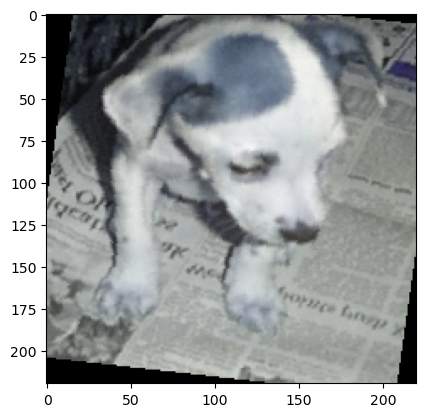

In [35]:
plt.imshow(train_dataset[12][0].permute(1, 2, 0));

In [42]:
train_dataset[12][1]

1

In [43]:
batch_size = 32

In [44]:
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=True, 
                          num_workers=0)

In [45]:
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         drop_last=False, 
                         num_workers=0)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 256, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 256, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, 3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256), 
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
device

device(type='cuda')

In [49]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=10**(-6))
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.2, patience=3)
#criterion = nn.CrossEntropyLoss().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)

In [340]:
epochs = 10

In [51]:
loss_arr = []
accuracy_arr = []
lr_arr = []
accuracy = 0.5

**Статистики, например, среднее можно считать с помощью скользящего среднего, а не суммировать каждый раз значения, а потом поделить на количество, так как это приводит к излишним тратам памяти. Результат будет одинаковым.**

$Q_m$ = $\frac{ε_{m}+ε_{m-1}+ε_{m-2}+...+ε_1}{m}$ = $\frac{1}{m}ε_m+\frac{1}{m}ε_{m-1}+\frac{1}{m}ε_{m-2}+...+\frac{1}{m}ε_1$

$m\cdot Q_m-ε_m$ = $ε_{m-1}+ε_{m-2}+ε_{m-3}+...+ε_1$

$Q_{m-1}$ = $\frac{1}{m-1}\cdot[m\cdot Q_m-ε_m]$ = $\frac{m}{m-1}Q_m - \frac{1}{m-1}ε_m$

$Q_m$ = $\frac{m-1}{m}Q_{m-1}+\frac{m-1}{m}\cdot \frac{1}{m-1}ε_m$

$Q_m$ = $\frac{1}{m}ε_m + (1-\frac{1}{m})Q_{m-1}$

In [5]:
mean = 0
m = 0
values_sum = 0

array = [1, 2, 2, 3, -1, 5, 10]
for value in array:
    values_sum += value                    # обычное среднее через суммирование всех значений
    m += 1
    mean = 1/m * value + (1 - 1/m) * mean  # среднее значение через скользящее среднее

print(values_sum / m)
print(mean)

3.142857142857143
3.142857142857143


In [341]:
for epoch in range(1, epochs+1):
    model.train()
    tqdm_pbar = tqdm(train_loader,
                     leave=False,  # если False, то прогресс-бар не остается после завершения
                     unit="batch")
    for images, labels in tqdm_pbar:
        images = images.to(device)
        labels = labels.unsqueeze(dim=1).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        text = f"[train] Epoch: [{epoch}/{epochs}] <Prev Accuracy>: {accuracy:.3f} <Loss>: {loss.item():.2f}|"
        tqdm_pbar.set_description(text)
        
    total = 0
    correct = 0
    
    model.eval()
    with torch.no_grad():
        loss = loss.item()
        tqdm_pbar = tqdm(test_loader, 
                         leave=True if epoch == epochs else False,
                         unit="batch")
        for images, labels in tqdm_pbar:
            images = images.to(device)
            labels = labels.unsqueeze(dim=1).float()
            labels = labels.to(device)
            
            outputs = model(images)
            
            #predicted = torch.argmax(outputs.data, 1)
            predicted = (torch.sigmoid(outputs) > 0.5) * 1.0
            #labels = torch.argmax(labels.data, 1)
            #(outputs.sigmoid() > 0.5) * 1.0
            
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            curr_acc = 100 * correct / total
            
            text = f"[test] Epoch: [{epoch}/{epochs}] <Prev Accuracy>: {accuracy:.3f} <Curr Accuracy>: {curr_acc:.3f}|"
            tqdm_pbar.set_description(text)
    
    accuracy = 100 * correct / total
    
    loss_arr.append(loss)
    accuracy_arr.append(accuracy)
    lr_arr.append(optimizer.param_groups[0]["lr"])
    
    sheduler.step(accuracy)

[test] Epoch: [10/10] <Prev Accuracy>: 96.955 <Curr Accuracy>: 96.895|: 100%|█████| 156/156 [00:34<00:00,  4.52batch/s]


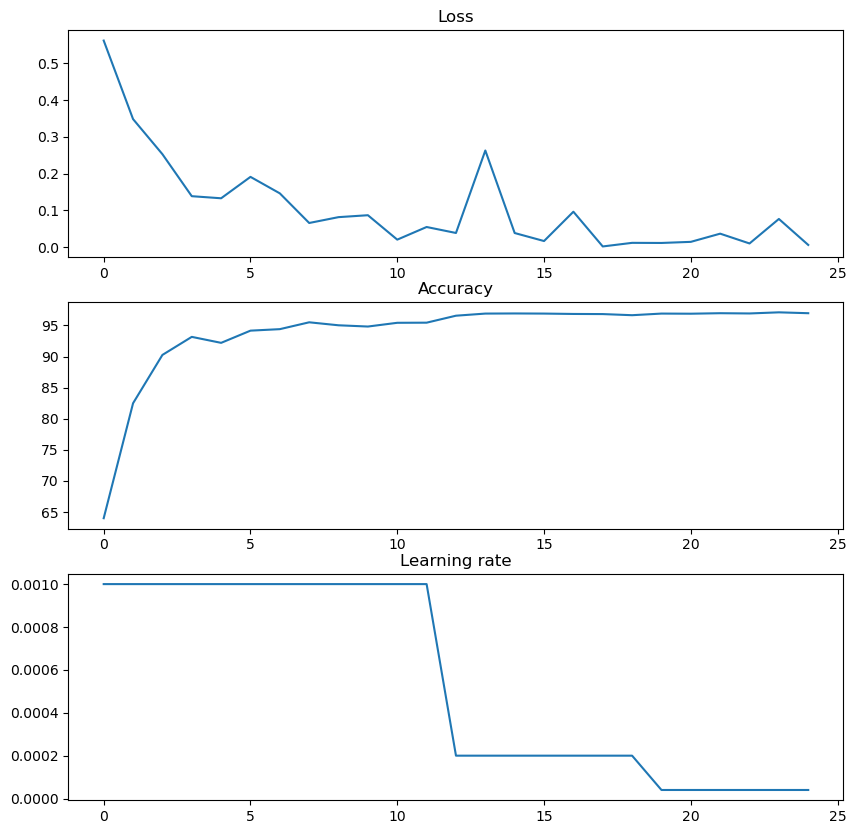

In [58]:
plt.figure(figsize=(10, 10));
plt.subplot(3, 1, 1);
plt.title("Loss");
plt.plot(loss_arr);

plt.subplot(3, 1, 2);
plt.title("Accuracy");
plt.plot(accuracy_arr);

plt.subplot(3, 1, 3);
plt.title("Learning rate");
plt.plot(lr_arr);

# Сохранение модели

In [10]:
model = model.to("cpu")

In [61]:
# model.state_dict() - сохранение состояния модели (всех необходимых весов)
# в файл "model.pth"
torch.save(model.state_dict(), "model.pth") 

In [27]:
# weights_only - если True, то будет загружать только примитивные типы, такие как тензоры, словари, списки, строки ...
# Если weights_only = False, то можно случайно загрузить вредоносный код
model = Model()
state_dict = torch.load("model.pth", weights_only=True)  
model.load_state_dict(state_dict);  # загружаем сохраненное состояние модели

In [63]:
model = model.to(device)

In [76]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.unsqueeze(dim=1).float()
        labels = labels.to(device)
            
        outputs = model(images)
            
        predicted = (torch.sigmoid(outputs) > 0.5) * 1.0
            
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total

100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:35<00:00,  4.36it/s]


In [77]:
accuracy

96.97516025641026

**Можно сохранять произвольные данные**

In [28]:
torch.save([1, 2, 3], "ex.tar")

In [30]:
torch.load("ex.tar", weights_only=True)

[1, 2, 3]

**Можно также сохранять состояния модели, если происходит значимое улучшение модели, чтобы если что-то случится с процессом обучения, можно было не обучать модель с нуля**

```python
best_loss = float("inf")

...
# обучение
...

if best_loss > current_loss * 1.1:
    best_loss = current_loss
    state_dict = model.state_dict()
    torch.save(state_dict, f"model_{i}.pth")
```

**Также возможность сохранять есть у оптимизаторов, трансформации и у некоторых других объектов**

In [48]:
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.005)

In [49]:
torch.save(optimizer.state_dict(), "optimizer.tar")

In [50]:
optimizer = optim.RMSprop(model.parameters(), lr=100, weight_decay=100)

In [51]:
optimizer

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 100
    maximize: False
    momentum: 0
    weight_decay: 100
)

In [52]:
optimizer.load_state_dict(torch.load("optimizer.tar", weights_only=True))

In [53]:
optimizer

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0.005
)